In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, confusion_matrix,
                              accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
                              silhouette_score, calinski_harabasz_score, davies_bouldin_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f'Importing Data_preprocess_3Omics processed datasets for direct fusion analysis')
print("=" * 80)

# Load the preprocessed datasets from Data_preprocess_3Omics pipeline
print("🔄 Loading preprocessed datasets...")
expression_scaled2 = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0)
methylation_scaled2 = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0)
copy_number_scaled2 = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0)
phenotype_data_clean2 = pd.read_csv("../NewDatasets/processed_phenotype_FXS_OG.csv", index_col=0)
labels = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

print("📊 Original Dataset Shapes (Features x Samples):")
print(f"   Expression: {expression_scaled2.shape} (genes x samples)")
print(f"   Methylation: {methylation_scaled2.shape} (CpG sites x samples)")
print(f"   Copy Number: {copy_number_scaled2.shape} (regions x samples)")
print(f"   Phenotype: {phenotype_data_clean2.shape} (samples x features)")
print(f"   Labels: {labels.shape} (samples)")

# Transpose omics data to have samples as rows (required for ML models)
print("\n🔄 Transposing omics data (samples as rows)...")
expression_scaled2 = expression_scaled2.T  # Now (samples x genes)
methylation_scaled2 = methylation_scaled2.T  # Now (samples x CpG sites)
copy_number_scaled2 = copy_number_scaled2.T  # Now (samples x regions)

expression_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=expression_scaled2.columns
)

methylation_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=methylation_scaled2.columns
)

copy_number_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=copy_number_scaled2.columns
)

print("\n✅ Omics data standardized (samples as rows, features scaled column-wise).")
# print("Expression data (final scaled shape):", expression_scaled_final.shape)

print("📊 After transpose (Samples x Features):")
print(f"   Expression: {expression_scaled2.shape} (samples x genes)")
print(f"   Methylation: {methylation_scaled2.shape} (samples x CpG sites)")
print(f"   Copy Number: {copy_number_scaled2.shape} (samples x regions)")

# Verify data quality (should have no missing values from preprocessing)
print("\n🔍 Data Quality Check:")
print(f"   Expression missing values: {expression_scaled2.isnull().sum().sum()}")
print(f"   Methylation missing values: {methylation_scaled2.isnull().sum().sum()}")
print(f"   Copy Number missing values: {copy_number_scaled2.isnull().sum().sum()}")
print(f"   Labels missing values: {labels.isnull().sum().sum()}")

# Check sample alignment (should be perfect from preprocessing)
common_samples_check = [
    set(expression_scaled2.index),
    set(methylation_scaled2.index), 
    set(copy_number_scaled2.index),
    set(labels.index)
]

all_aligned = all(s == common_samples_check[0] for s in common_samples_check)
print(f"\n✅ Sample alignment: {'Perfect' if all_aligned else 'Misaligned'}")
print(f"📊 Total samples: {len(expression_scaled2)}")


Importing Data_preprocess_3Omics processed datasets for direct fusion analysis
🔄 Loading preprocessed datasets...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...

✅ Omics data standardized (samples as rows, features scaled column-wise).
📊 After transpose (Samples x Features):
   Expression: (205, 44663) (samples x genes)
   Methylation: (205, 419542) (samples x CpG sites)
   Copy Number: (205, 56756) (samples x

In [3]:
# Create direct fusion of omics data (no PCA)
print("Creating Direct Fusion of Multi-Omics Data (No PCA)...")
print("=" * 80)
# Option 1: Multi-omics only (raw, no PCA)
fraw_data_omics = pd.concat([
    expression_scaled2, 
    methylation_scaled2, 
    copy_number_scaled2
], axis=1)
print(f"🧬 Direct omics fusion shape: {fraw_data_omics.shape}")
print(f"   - Expression features: {expression_scaled2.shape[1]:,}")
print(f"   - Methylation features: {methylation_scaled2.shape[1]:,}")
print(f"   - CNV features: {copy_number_scaled2.shape[1]:,}")

# Verify no missing values
print(f"\n🔍 Data Quality Check:")
print(f"   Omics-only missing values: {fraw_data_omics.isnull().sum().sum()}")

# Store fusion options
fusion_options = {
    'direct_original': fraw_data_omics
}
# Apply PCA with 100 and 50 components to all omics (with and without phenotype)
n_components_list = [100, 50, 30]

# Standardize before PCA
scaler_omics = StandardScaler()
omics_scaled = scaler_omics.fit_transform(fraw_data_omics)

# PCA with 30 components
pca_30_omics = PCA(n_components=30, random_state=42)
fpca_data30_omics = pd.DataFrame(
    pca_30_omics.fit_transform(omics_scaled),
    index=fraw_data_omics.index
)

# PCA with 100 components
pca_100_omics = PCA(n_components=100, random_state=42)
fpca_data100_omics = pd.DataFrame(
    pca_100_omics.fit_transform(omics_scaled),
    index=fraw_data_omics.index
)

# PCA with 50 components
pca_50_omics = PCA(n_components=50, random_state=42)
fpca_data50_omics = pd.DataFrame(
    pca_50_omics.fit_transform(omics_scaled),
    index=fraw_data_omics.index
)

# Add to fusion options
fusion_options['fpca_data100_omics'] = fpca_data100_omics
fusion_options['fpca_data50_omics'] = fpca_data50_omics
fusion_options['fpca_data30_omics'] = fpca_data30_omics

print(f"\n📊 PCA Fusion Results:")
print(f"🔹 PCA(100) omics fusion shape: {fpca_data100_omics.shape}")
print(f"   Variance explained: {pca_100_omics.explained_variance_ratio_.sum():.4f} ({pca_100_omics.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"🔹 PCA(50) omics fusion shape: {fpca_data50_omics.shape}")
print(f"   Variance explained: {pca_50_omics.explained_variance_ratio_.sum():.4f} ({pca_50_omics.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"🔹 PCA(30) omics fusion shape: {fpca_data30_omics.shape}")
print(f"   Variance explained: {pca_30_omics.explained_variance_ratio_.sum():.4f} ({pca_30_omics.explained_variance_ratio_.sum()*100:.2f}%)" )


print(f"\n✅ Data fusion and PCA transformation completed!")
print(f"📋 Available fusion options:")
for key in fusion_options.keys():
    print(f"   - {key}: {fusion_options[key].shape}")

Creating Direct Fusion of Multi-Omics Data (No PCA)...
🧬 Direct omics fusion shape: (205, 520961)
   - Expression features: 44,663
   - Methylation features: 419,542
   - CNV features: 56,756

🔍 Data Quality Check:
🧬 Direct omics fusion shape: (205, 520961)
   - Expression features: 44,663
   - Methylation features: 419,542
   - CNV features: 56,756

🔍 Data Quality Check:
   Omics-only missing values: 0
   Omics-only missing values: 0

📊 PCA Fusion Results:
🔹 PCA(100) omics fusion shape: (205, 100)
   Variance explained: 0.7904 (79.04%)
🔹 PCA(50) omics fusion shape: (205, 50)
   Variance explained: 0.6248 (62.48%)
🔹 PCA(30) omics fusion shape: (205, 30)
   Variance explained: 0.5290 (52.90%)

✅ Data fusion and PCA transformation completed!
📋 Available fusion options:
   - direct_original: (205, 520961)
   - fpca_data100_omics: (205, 100)
   - fpca_data50_omics: (205, 50)
   - fpca_data30_omics: (205, 30)

📊 PCA Fusion Results:
🔹 PCA(100) omics fusion shape: (205, 100)
   Variance expla

# Autoencoder-Based Analysis Pipeline

This section implements autoencoder-based dimensionality reduction followed by machine learning classification.

In [4]:
# Autoencoder Class and Training Function
print("AUTOENCODER ARCHITECTURE DEFINITION")
print("=" * 80)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def train_autoencoder(model, data, device, epochs=300, lr=0.001, patience=10):
    # Split data for training and validation
    data_np = data.cpu().numpy() if torch.is_tensor(data) else data
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        x_recon, _ = model(X_train_tensor)
        train_loss = criterion(x_recon, X_train_tensor)
        train_loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_recon, _ = model(X_val_tensor)
            val_loss = criterion(val_recon, X_val_tensor)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        # Early stopping check
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

print("✅ Autoencoder class and training function defined!")
print(f"   Architecture: Input → 256 → Latent → 256 → Output (2 layers)")
print(f"   Features: Dropout regularization, early stopping, MSE loss")

AUTOENCODER ARCHITECTURE DEFINITION
✅ Autoencoder class and training function defined!
   Architecture: Input → 256 → Latent → 256 → Output (2 layers)
   Features: Dropout regularization, early stopping, MSE loss


In [5]:
# ML Models Evaluation Function
print("MACHINE LEARNING MODELS DEFINITION")
print("=" * 80)

def evaluate_ml_models_on_embeddings(embeddings, labels, k_folds=5):
    """
    Evaluate multiple ML classifiers on autoencoder embeddings
    
    Args:
        embeddings: Latent representations from autoencoder
        labels: Target labels
        k_folds: Number of cross-validation folds
        
    Returns:
        Dictionary with comprehensive metrics for each model
    """
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
        'SVM_RBF': SVC(kernel='rbf', random_state=42, probability=True),
        'KNN': KNeighborsClassifier(n_neighbors=4),
        'NaiveBayes': GaussianNB()
    }
    
    results = {}
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Split data into train and test sets for proper evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    for model_name, model in models.items():
        print(f"\n⚙️  Training {model_name}...")
        
        # Cross-validation scores (on full data for comparison)
        cv_scores = cross_val_score(model, embeddings, labels, cv=skf, scoring='accuracy')
        
        # Train on train set and evaluate on test set (PROPER EVALUATION)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Calculate comprehensive metrics on TEST SET
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        
        # AUC (one-vs-rest for multiclass)
        try:
            n_classes = len(np.unique(y_test))
            if n_classes == 2:
                auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
        except:
            auc = None
        
        # C-index (concordance index)
        try:
            c_index = concordance_index(y_test, y_pred_proba.max(axis=1))
        except:
            c_index = None
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'precision': precision,
            'recall': recall,
            'auc': auc,
            'c_index': c_index,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'confusion_matrix': cm
        }
        
        print(f"   ✅ {model_name}: Accuracy={accuracy:.4f}, F1_macro={f1_macro:.4f}, F1_micro={f1_micro:.4f}")
    
    return results

print("✅ ML evaluation function defined!")
print(f"   Models: RandomForest, GradientBoosting, LogisticRegression, SVM, KNN, NaiveBayes")
print(f"   Metrics: accuracy, f1_macro, f1_micro, precision, recall, AUC, c-index, CV scores")

MACHINE LEARNING MODELS DEFINITION
✅ ML evaluation function defined!
   Models: RandomForest, GradientBoosting, LogisticRegression, SVM, KNN, NaiveBayes
   Metrics: accuracy, f1_macro, f1_micro, precision, recall, AUC, c-index, CV scores


In [10]:
# Execute Autoencoder Pipeline and Store Results
print("AUTOENCODER PIPELINE EXECUTION")
print("=" * 80)

# Initialize results dictionary
ae_scores = {}
ae_embeddings = {}  # Store embeddings for visualization

# Latent dimensions to test
latent_dims = [64, 128]

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}\n")

# Fusion options to evaluate
fusion_configs = {
    'fusion_pca100': (fpca_data100_omics.values, 'PCA-100'),
    'fusion_pca50': (fpca_data50_omics.values, 'PCA-50'),
    'fusion_pca30': (fpca_data30_omics.values, 'PCA-30')
}

for fusion_name, (fusion_data, fusion_desc) in fusion_configs.items():
    print(f"\n{'='*80}")
    print(f"🔬 Processing: {fusion_desc}")
    print(f"{'='*80}")
    
    for latent_dim in latent_dims:
        print(f"\n📊 Latent Dimension: {latent_dim}")
        print("-" * 80)
        
        # Prepare data
        X = fusion_data
        y = labels.values.ravel()
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        
        # Initialize and train autoencoder
        print(f"🧠 Training Autoencoder (latent_dim={latent_dim})...")
        ae_model = Autoencoder(input_dim=X_scaled.shape[1], latent_dim=latent_dim).to(device)
        ae_model, history = train_autoencoder(ae_model, X_tensor, device, epochs=100, patience=15)
        
        # Extract latent embeddings
        ae_model.eval()
        with torch.no_grad():
            _, embeddings = ae_model(X_tensor)
            embeddings_np = embeddings.cpu().numpy()
        
        print(f"   ✅ Embeddings shape: {embeddings_np.shape}")
        
        # Evaluate ML models on embeddings
        print(f"\n🤖 Evaluating ML Models on Embeddings...")
        ml_results = evaluate_ml_models_on_embeddings(embeddings_np, y, k_folds=5)
        
        # Calculate clustering metrics
        print(f"\n📈 Computing Clustering Metrics...")
        n_clusters = len(np.unique(y))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings_np)
        
        ari = adjusted_rand_score(y, cluster_labels)
        nmi = normalized_mutual_info_score(y, cluster_labels)
        silhouette = silhouette_score(embeddings_np, cluster_labels)
        calinski = calinski_harabasz_score(embeddings_np, cluster_labels)
        davies = davies_bouldin_score(embeddings_np, cluster_labels)
        
        print(f"   ARI: {ari:.4f} | NMI: {nmi:.4f} | Silhouette: {silhouette:.4f}")
        print(f"   Calinski-Harabasz: {calinski:.2f} | Davies-Bouldin: {davies:.4f}")
        
        # Latent stability (reconstruction error)
        ae_model.eval()
        with torch.no_grad():
            recon, _ = ae_model(X_tensor)
            recon_error = nn.MSELoss()(recon, X_tensor).item()
        
        # Store results
        config_key = f"{fusion_name}_latent{latent_dim}"
        ae_scores[config_key] = {
            'fusion_type': fusion_desc,
            'latent_dim': latent_dim,
            'ml_models': ml_results,
            'ari': ari,
            'nmi': nmi,
            'silhouette': silhouette,
            'calinski_harabasz': calinski,
            'davies_bouldin': davies,
            'reconstruction_error': recon_error,
            'embeddings_shape': embeddings_np.shape,
            'train_history': history
        }
        
        # Store embeddings for visualization reuse
        ae_embeddings[config_key] = embeddings_np
        
        print(f"\n✅ Results saved to ae_scores['{config_key}']")

print(f"\n{'='*80}")
print(f"🎉 AUTOENCODER PIPELINE COMPLETED!")
print(f"{'='*80}")
print(f"Total configurations evaluated: {len(ae_scores)}")
print(f"Results stored in 'ae_scores' dictionary")
print(f"\nConfiguration keys:")
for key in ae_scores.keys():
    print(f"   • {key}")

AUTOENCODER PIPELINE EXECUTION
🖥️  Using device: cuda


🔬 Processing: PCA-100

📊 Latent Dimension: 64
--------------------------------------------------------------------------------
🧠 Training Autoencoder (latent_dim=64)...
   ✅ Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...
   ✅ Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.4878, F1_macro=0.2483, F1_micro=0.4878

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.4146, F1_macro=0.3121, F1_micro=0.4146

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.5610, F1_macro=0.4865, F1_micro=0.5610

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5122, F1_macro=0.2407, F1_micro=0.5122

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.4878, F1_macro=0.4754, F1_micro=0.4878

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.4146, F1_macro=0.2904, F1_micro=0.4146

📈 Computing Clustering Metrics...
   ARI: -0.0134 | NMI: 0.0199 | Silhouette: 0.0378
   Calinski-Harabasz: 3.53 | Davies-Bouldin: 4.1686

✅ Results saved to ae_scores['fusion_pca100_latent64']

📊 Latent Dimension: 128
--------------------------------------------------------------------------------
🧠 Training Autoencoder (latent_dim=128)...
   ✅ GradientBoosting: Accuracy=0.4146, F1_macro=0.3121, F1_micro=0.4146

⚙️  Training LogisticRegression

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.5366, F1_macro=0.2875, F1_micro=0.5366

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.5122, F1_macro=0.4722, F1_micro=0.5122

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.6341, F1_macro=0.5141, F1_micro=0.6341

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3290, F1_micro=0.5854

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.5122, F1_macro=0.4166, F1_micro=0.5122

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.4390, F1_macro=0.3215, F1_micro=0.4390

📈 Computing Clustering Metrics...
   ✅ GradientBoosting: Accuracy=0.5122, F1_macro=0.4722, F1_micro=0.5122

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.6341, F1_macro=0.5141, F1_micro=0.6341

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3290, F1_micro=0.5854

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.5122, F1_macro=0.4166, F1_micro=0.5122

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.439

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ARI: -0.0351 | NMI: 0.0206 | Silhouette: 0.0930
   Calinski-Harabasz: 3.15 | Davies-Bouldin: 4.6507

✅ Results saved to ae_scores['fusion_pca100_latent128']

🔬 Processing: PCA-50

📊 Latent Dimension: 64
--------------------------------------------------------------------------------
🧠 Training Autoencoder (latent_dim=64)...
   ✅ Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...
   ✅ Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...
   ✅ RandomForest: Accuracy=0.6585, F1_macro=0.4665, F1_micro=0.6585

⚙️  Training GradientBoosting...
   ✅ RandomForest: Accuracy=0.6585, F1_macro=0.4665, F1_micro=0.6585

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.6098, F1_macro=0.5196, F1_micro=0.6098

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.8049, F1_macro=0.7214, F1_micro=0.8049

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.7317, F1_macro=0.6250, 

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

🧠 Training Autoencoder (latent_dim=128)...
   ✅ Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...
   ✅ Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.6585, F1_macro=0.3805, F1_micro=0.6585

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.5366, F1_macro=0.3637, F1_micro=0.5366

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7805, F1_macro=0.7063, F1_micro=0.7805

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.6829, F1_macro=0.5431, F1_micro=0.6829

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.6829, F1_macro=0.5611, F1_micro=0.6829

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.6341, F1_macro=0.4914, F1_micro=0.6341

📈 Computing Clustering Metrics...
   ✅ GradientBoosting: Accuracy=0.5366, F1_macro=0.3637, F1_micro=0.5366

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7805, F1_macro=0.7063, F1_micro=0.7805

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.6829, F1_macro=0.5431, F1_micro=0.6829

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.6829, F1_macro=0.5611, F1_micro=0.6829

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.634

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ARI: 0.0394 | NMI: 0.0813 | Silhouette: 0.0216
   Calinski-Harabasz: 4.17 | Davies-Bouldin: 3.3701

✅ Results saved to ae_scores['fusion_pca50_latent128']

🔬 Processing: PCA-30

📊 Latent Dimension: 64
--------------------------------------------------------------------------------
🧠 Training Autoencoder (latent_dim=64)...
   ✅ Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...
   ✅ Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...
   ✅ RandomForest: Accuracy=0.7317, F1_macro=0.6116, F1_micro=0.7317

⚙️  Training GradientBoosting...
   ✅ RandomForest: Accuracy=0.7317, F1_macro=0.6116, F1_micro=0.7317

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.5854, F1_macro=0.4882, F1_micro=0.5854

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7561, F1_macro=0.6527, F1_micro=0.7561

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.7317, F1_macro=0.6040, F1

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ARI: 0.0274 | NMI: 0.0643 | Silhouette: 0.0410
   Calinski-Harabasz: 6.68 | Davies-Bouldin: 2.8191

✅ Results saved to ae_scores['fusion_pca30_latent64']

📊 Latent Dimension: 128
--------------------------------------------------------------------------------
🧠 Training Autoencoder (latent_dim=128)...
   ✅ Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...
   ✅ Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.7073, F1_macro=0.4900, F1_micro=0.7073

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.6098, F1_macro=0.4785, F1_micro=0.6098

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.8049, F1_macro=0.7288, F1_micro=0.8049

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.7317, F1_macro=0.5976, F1_micro=0.7317

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.7073, F1_macro=0.6114, F1_micro=0.7073

⚙️  Training NaiveBayes...
   ✅ GradientBoosting: Accuracy=0.6098, F1_macro=0.4785, F1_micro=0.6098

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.8049, F1_macro=0.7288, F1_micro=0.8049

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.7317, F1_macro=0.5976, F1_micro=0.7317

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.7073, F1_macro=0.6114, F1_micro=0.7073

⚙️  Training NaiveBayes...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ NaiveBayes: Accuracy=0.7317, F1_macro=0.6657, F1_micro=0.7317

📈 Computing Clustering Metrics...
   ARI: 0.0303 | NMI: 0.0634 | Silhouette: 0.0293
   Calinski-Harabasz: 5.86 | Davies-Bouldin: 3.4987

✅ Results saved to ae_scores['fusion_pca30_latent128']

🎉 AUTOENCODER PIPELINE COMPLETED!
Total configurations evaluated: 6
Results stored in 'ae_scores' dictionary

Configuration keys:
   • fusion_pca100_latent64
   • fusion_pca100_latent128
   • fusion_pca50_latent64
   • fusion_pca50_latent128
   • fusion_pca30_latent64
   • fusion_pca30_latent128


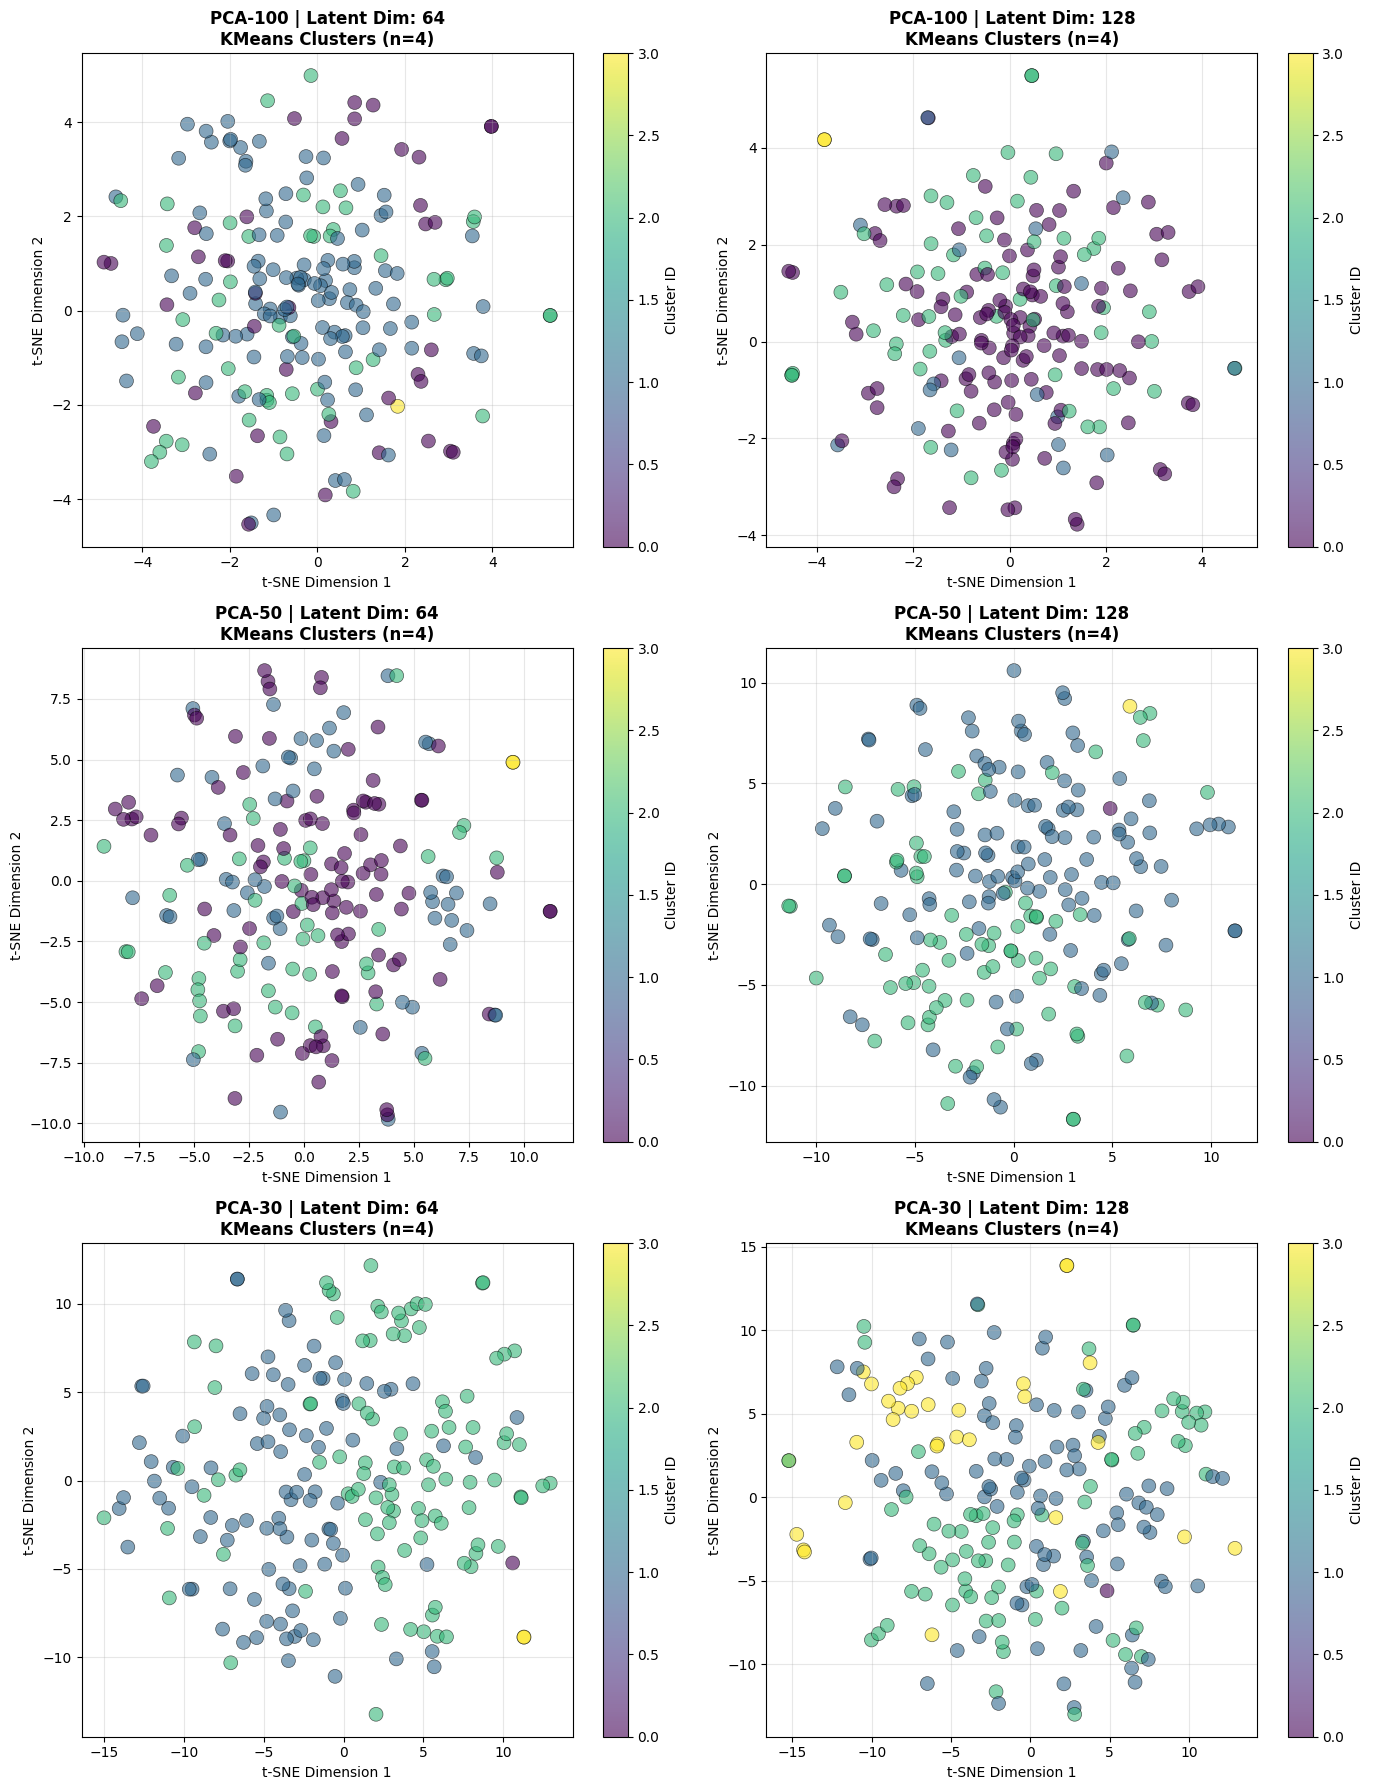


✅ Visualization completed for 6 configurations!
   Each plot shows KMeans clustering in 2D space (via t-SNE)
   Embeddings reused from Cell 8 pipeline


In [11]:

n_configs = len(ae_scores)
n_rows = (n_configs + 1) // 2  # Calculate rows needed for 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 6 * n_rows))

# Handle single row case
if n_rows == 1:
    axes = axes.reshape(1, -1)

axes = axes.flatten()

for idx, (config_key, results) in enumerate(ae_scores.items()):
    # Get the embeddings from the stored results (reuse from Cell 8)
    fusion_type = results['fusion_type']
    latent_dim = results['latent_dim']
    
    # Check if embeddings are already stored in the pipeline
    if config_key not in ae_embeddings:
        # If not stored, we need to regenerate (shouldn't happen if Cell 8 ran properly)
        print(f"⚠️  Regenerating embeddings for {config_key}...")
        
        # Determine which fusion data to use
        if 'PCA-100' in fusion_type:
            fusion_data = fpca_data100_omics.values
        elif 'PCA-50' in fusion_type:
            fusion_data = fpca_data50_omics.values
        else:  # PCA-30
            fusion_data = fpca_data30_omics.values
        
        # Prepare data
        X = fusion_data
        y = labels.values.ravel()
        
        # Standardize and get embeddings
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        
        # Get the trained model from ae_scores
        # We need to recreate it since we don't store the model itself
        ae_model = Autoencoder(input_dim=X_scaled.shape[1], latent_dim=latent_dim).to(device)
        ae_model, _ = train_autoencoder(ae_model, X_tensor, device, epochs=100, patience=15)
        
        # Extract embeddings
        ae_model.eval()
        with torch.no_grad():
            _, embeddings = ae_model(X_tensor)
            embeddings_np = embeddings.cpu().numpy()
        
        ae_embeddings[config_key] = embeddings_np
    else:
        embeddings_np = ae_embeddings[config_key]
    
    # Get labels
    y = labels.values.ravel()
    
    # Apply t-SNE for 2D visualization (if latent_dim > 2)
    if latent_dim > 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_np)-1))
        embeddings_2d = tsne.fit_transform(embeddings_np)
    else:
        embeddings_2d = embeddings_np[:, :2]
    
    # Use KMeans for cluster assignment
    n_clusters = len(np.unique(y))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings_np)
    
    # Plot
    ax = axes[idx]
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=cluster_labels, cmap='viridis', 
                        s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Add title and labels
    ax.set_title(f'{fusion_type} | Latent Dim: {latent_dim}\nKMeans Clusters (n={n_clusters})', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('t-SNE Dimension 1' if latent_dim > 2 else 'Latent Dimension 1', fontsize=10)
    ax.set_ylabel('t-SNE Dimension 2' if latent_dim > 2 else 'Latent Dimension 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Cluster ID')

# Remove extra subplots if odd number of configurations
for idx in range(len(ae_scores), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
# plt.suptitle('KMeans Cluster Visualization of Autoencoder Embeddings', 
#             fontsize=16, fontweight='bold', y=1.00)
plt.show()

print(f"\n✅ Visualization completed for {len(ae_scores)} configurations!")
print(f"   Each plot shows KMeans clustering in 2D space (via t-SNE)")
print(f"   Embeddings reused from Cell 8 pipeline")

In [12]:
# Display Evaluation Results in Tables
print("=" * 100)
print("📊 AUTOENCODER PIPELINE EVALUATION RESULTS")
print("=" * 100)

# ============================================================================
# TABLE 1: ML MODEL PERFORMANCE METRICS
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 1: MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 100)

# Collect all ML model results
ml_results_table = []

for config_key, results in ae_scores.items():
    fusion_type = results['fusion_type']
    latent_dim = results['latent_dim']
    
    for model_name, metrics in results['ml_models'].items():
        row = {
            'Configuration': f"{fusion_type}_L{latent_dim}",
            'Fusion Type': fusion_type,
            'Latent Dim': latent_dim,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1-Macro': metrics['f1_macro'],
            'F1-Micro': metrics['f1_micro'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'AUC': metrics['auc'] if metrics['auc'] is not None else np.nan,
            'C-Index': metrics['c_index'] if metrics['c_index'] is not None else np.nan,
            'CV-Mean': metrics['cv_mean'],
            'CV-Std': metrics['cv_std']
        }
        ml_results_table.append(row)

# Create DataFrame
ml_df = pd.DataFrame(ml_results_table)

# Display full table with proper formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("\n📋 Complete ML Model Performance Table:")
print("-" * 100)
print(ml_df.to_string(index=False))

# ============================================================================
# TABLE 2: STABILITY & CLUSTERING METRICS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2: STABILITY & CLUSTERING METRICS")
print("=" * 100)

# Collect stability metrics
stability_table = []

for config_key, results in ae_scores.items():
    fusion_type = results['fusion_type']
    latent_dim = results['latent_dim']
    
    row = {
        'Configuration': f"{fusion_type}_L{latent_dim}",
        'Fusion Type': fusion_type,
        'Latent Dim': latent_dim,
        'ARI': results['ari'],
        'NMI': results['nmi'],
        'Silhouette': results['silhouette'],
        'Calinski-Harabasz': results['calinski_harabasz'],
        'Davies-Bouldin': results['davies_bouldin'],
        'Reconstruction Error': results['reconstruction_error'],
        'Embedding Shape': f"{results['embeddings_shape'][0]}x{results['embeddings_shape'][1]}"
    }
    stability_table.append(row)

# Create DataFrame
stability_df = pd.DataFrame(stability_table)

print("\n📋 Complete Stability & Clustering Metrics Table:")
print("-" * 100)
print(stability_df.to_string(index=False))

📊 AUTOENCODER PIPELINE EVALUATION RESULTS

TABLE 1: MACHINE LEARNING MODEL PERFORMANCE

📋 Complete ML Model Performance Table:
----------------------------------------------------------------------------------------------------
Configuration Fusion Type  Latent Dim              Model  Accuracy  F1-Macro  F1-Micro  Precision  Recall    AUC  C-Index  CV-Mean  CV-Std
  PCA-100_L64     PCA-100          64       RandomForest    0.4878    0.2483    0.4878     0.2681  0.2919 0.7116   0.5326   0.5659  0.0473
  PCA-100_L64     PCA-100          64   GradientBoosting    0.4146    0.3121    0.4146     0.3060  0.3209 0.6273   0.5362   0.5024  0.0839
  PCA-100_L64     PCA-100          64 LogisticRegression    0.5610    0.4865    0.5610     0.5043  0.4943 0.8063   0.6561   0.5366  0.0690
  PCA-100_L64     PCA-100          64            SVM_RBF    0.5122    0.2407    0.5122     0.3718  0.2955 0.8004   0.5944   0.5317  0.0473
  PCA-100_L64     PCA-100          64                KNN    0.4878    0.4754 

📈 AUC-ROC CURVES FOR ALL MODELS


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

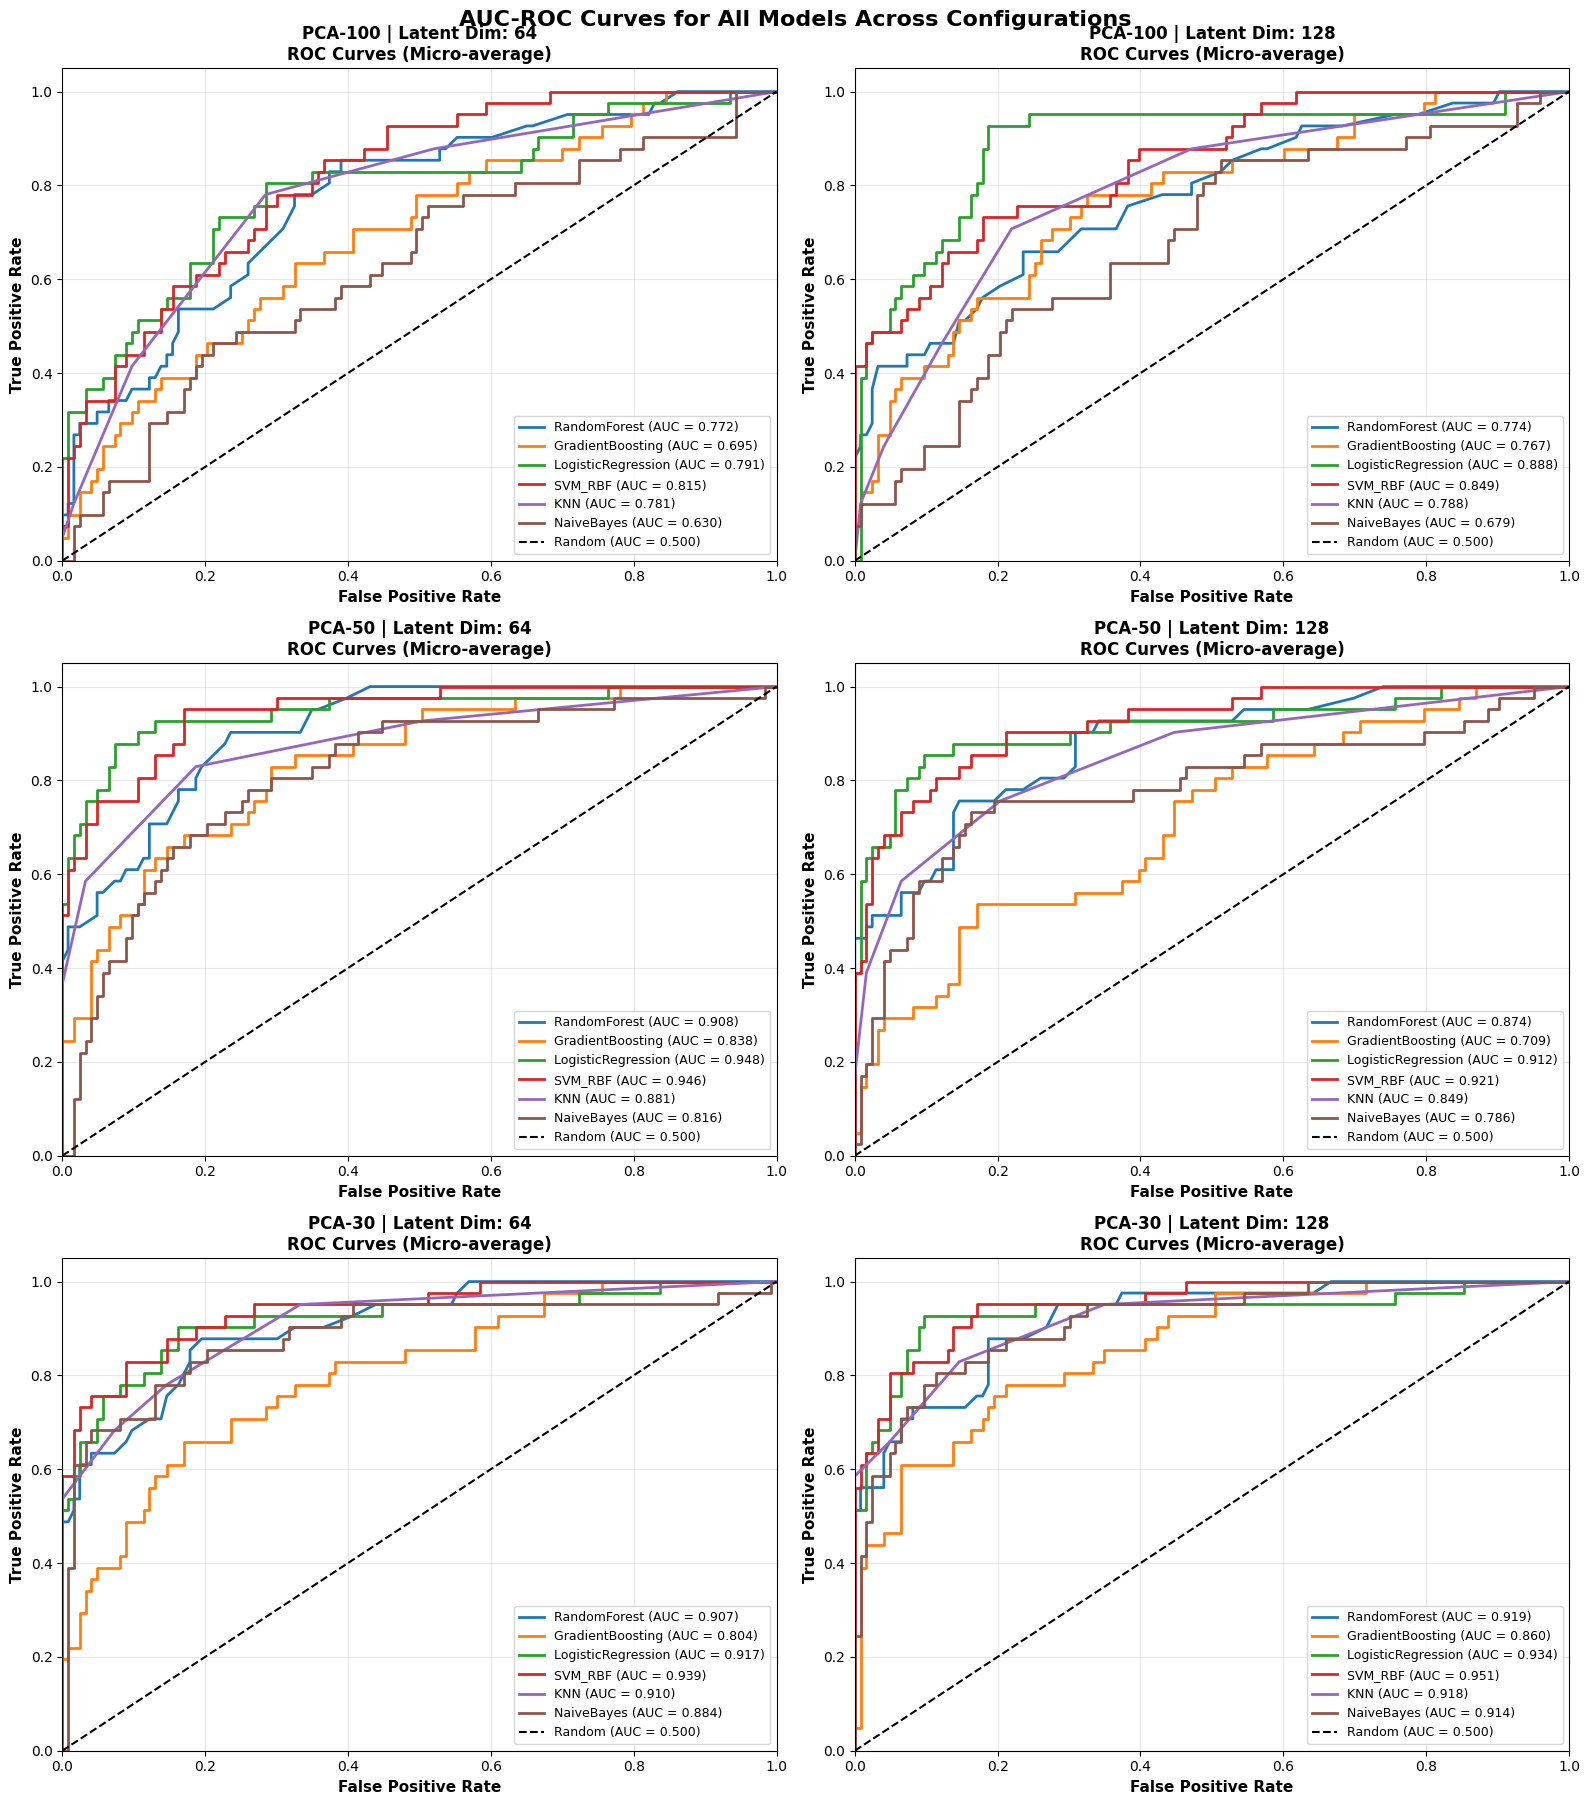


✅ ROC curves plotted for 6 configurations!
   Each subplot shows all 6 models for comparison
   Multiclass (micro-average) ROC curves
   Figure saved as: autoencoder_roc_curves.png

📊 AUC SUMMARY TABLE

📋 AUC Scores by Configuration and Model:
----------------------------------------------------------------------------------------------------
Configuration Fusion Type  Latent Dim              Model    AUC
  PCA-100_L64     PCA-100          64       RandomForest 0.7116
  PCA-100_L64     PCA-100          64   GradientBoosting 0.6273
  PCA-100_L64     PCA-100          64 LogisticRegression 0.8063
  PCA-100_L64     PCA-100          64            SVM_RBF 0.8004
  PCA-100_L64     PCA-100          64                KNN 0.7446
  PCA-100_L64     PCA-100          64         NaiveBayes 0.5242
 PCA-100_L128     PCA-100         128       RandomForest 0.7192
 PCA-100_L128     PCA-100         128   GradientBoosting 0.7429
 PCA-100_L128     PCA-100         128 LogisticRegression 0.8305
 PCA-100_L128 

In [13]:
# Plot AUC-ROC Curves for All Models
print("=" * 100)
print("📈 AUC-ROC CURVES FOR ALL MODELS")
print("=" * 100)

from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Get unique configurations
configs = list(ae_scores.keys())
n_configs = len(configs)

# Create subplots (2 columns layout)
n_rows = (n_configs + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 6 * n_rows))

# Handle single row case
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Color palette for different models
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])

for idx, config_key in enumerate(configs):
    ax = axes[idx]
    results = ae_scores[config_key]
    fusion_type = results['fusion_type']
    latent_dim = results['latent_dim']
    
    # Get embeddings and labels
    embeddings_np = ae_embeddings[config_key]
    y = labels.values.ravel()
    
    # Get unique classes
    classes = np.unique(y)
    n_classes = len(classes)
    
    # Binarize labels for multiclass ROC
    y_bin = label_binarize(y, classes=classes)
    
    # Store all model ROC curves
    model_colors = {}
    color_iter = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    
    for model_name in results['ml_models'].keys():
        model_colors[model_name] = next(color_iter)
    
    # Train each model and plot ROC curve
    for model_name, metrics in results['ml_models'].items():
        # Define model
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
        elif model_name == 'SVM_RBF':
            model = SVC(kernel='rbf', random_state=42, probability=True)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=5)
        elif model_name == 'NaiveBayes':
            model = GaussianNB()
        
        # Split data for proper evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings_np, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train model on training set and predict on test set
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        
        # Binarize test labels for ROC
        y_test_bin = label_binarize(y_test, classes=classes)
        
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        if n_classes == 2:
            # Binary classification
            fpr[0], tpr[0], _ = roc_curve(y_test_bin.ravel(), y_score[:, 1])
            roc_auc[0] = auc(fpr[0], tpr[0])
            ax.plot(fpr[0], tpr[0], color=model_colors[model_name], lw=2,
                   label=f'{model_name} (AUC = {roc_auc[0]:.3f})')
        else:
            # Multiclass - compute micro-average ROC curve
            fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            ax.plot(fpr["micro"], tpr["micro"], color=model_colors[model_name], lw=2,
                   label=f'{model_name} (AUC = {roc_auc["micro"]:.3f})')
    
    # Plot diagonal line (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC = 0.500)')
    
    # Formatting
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{fusion_type} | Latent Dim: {latent_dim}\nROC Curves ({"Binary" if n_classes == 2 else "Micro-average"})', 
                fontsize=12, fontweight='bold')
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(True, alpha=0.3)

# Remove extra subplots if odd number of configurations
for idx in range(n_configs, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('AUC-ROC Curves for All Models Across Configurations', 
            fontsize=16, fontweight='bold', y=1.00)
plt.show()

print(f"\n✅ ROC curves plotted for {n_configs} configurations!")
print(f"   Each subplot shows all 6 models for comparison")
print(f"   {"Binary classification" if n_classes == 2 else "Multiclass (micro-average) ROC curves"}")
print(f"   Figure saved as: autoencoder_roc_curves.png")

# ============================================================================
# Summary Table: AUC Scores for All Models
# ============================================================================
print("\n" + "=" * 100)
print("📊 AUC SUMMARY TABLE")
print("=" * 100)

auc_summary = []
for config_key in configs:
    results = ae_scores[config_key]
    fusion_type = results['fusion_type']
    latent_dim = results['latent_dim']
    
    for model_name, metrics in results['ml_models'].items():
        auc_val = metrics['auc'] if metrics['auc'] is not None else np.nan
        auc_summary.append({
            'Configuration': f"{fusion_type}_L{latent_dim}",
            'Fusion Type': fusion_type,
            'Latent Dim': latent_dim,
            'Model': model_name,
            'AUC': auc_val
        })

auc_df = pd.DataFrame(auc_summary)
print("\n📋 AUC Scores by Configuration and Model:")
print("-" * 100)
print(auc_df.to_string(index=False))